# Sentiment_classification
AIFFEL 대전 탐색 노드 4   
네이버 영화리뷰 감성분석하는 프로젝트이다.   
프로세스는 다음과 같다.    
1. 데이터 준비와 확인   
2. 데이터로더 구성   
3. 모델구성을 위한 데이터 분석 및 가공   
4. 모델구성 및 validation set 구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석
8. 한국어 Word2Vec 임베딩 활용하여 성능개선

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. (load)
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
#check the data size
print(len(train_data))
print(len(test_data))
train_data.head()

150000
50000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성  (전처리)
텍스트 데이터를 모델에 입력할 수 있도록 숫자로 변환해 주는 작업이다.

In [2]:
# using konlpy
from konlpy.tag import Mecab
tokenizer = Mecab()
#미리 정의한 불용어
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] 
num_words = 10000

# 함수 기능
# 데이터의 중복 제거   
# NaN 결측치 제거   
# 한국어 토크나이저로 토큰화   
# 불용어(Stopwords) 제거   
# 사전word_to_index 구성   
# 텍스트 스트링을 사전 인덱스 스트링으로 변환   
# X_train, y_train, X_test, y_test, word_to_index 리턴   
def load_data(train_data, test_data, num_words=num_words):
    # 중복, 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    # 사전 구성
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    # 변환 text to index
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [3]:
# index to text 사전
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공   
데이터를 분석하여 훈련에 방해되는 것들을 제거하고 입력의 형식을 맞추는 정제 작업을 한다.
 -   데이터셋 내 문장 길이 분포   
 -   적절한 최대 문장 길이 지정   
 -   keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가   
 

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 한다  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
# 패딩 추가 (using keras.preprocessing.sequence.pad_sequences)
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성   
모델은 3가지 이상 다양하게 구성한다.
- LSTM(RNN) 이용
- Conv 이용
- Maxpooling 이용

In [7]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계
# 1 using LSTM
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 2 using conv
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# 3 using maxpooling
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()
model2.summary()
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 8)                 1608      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
________________________

In [8]:
# validation set 50000건 분리
x_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## 5) 모델 훈련 개시

In [9]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 6s 34ms/step - loss: 0.4415 - accuracy: 0.7979 - val_loss: 0.3466 - val_accuracy: 0.8478
Epoch 2/20
188/188 [==============================] - 6s 32ms/step - loss: 0.3237 - accuracy: 0.8624 - val_loss: 0.3406 - val_accuracy: 0.8528
Epoch 3/20
188/188 [==============================] - 6s 32ms/step - loss: 0.2885 - accuracy: 0.8790 - val_loss: 0.3334 - val_accuracy: 0.8556
Epoch 4/20
188/188 [==============================] - 6s 33ms/step - loss: 0.2549 - accuracy: 0.8935 - val_loss: 0.3403 - val_accuracy: 0.8565
Epoch 5/20
188/188 [==============================] - 6s 34ms/step - loss: 0.2264 - accuracy: 0.9063 - val_loss: 0.3563 - val_accuracy: 0.8538
Epoch 6/20
188/188 [==============================] - 7s 35ms/step - loss: 0.1997 - accuracy: 0.9187 - val_loss: 0.4051 - val_accuracy: 0.8526
Epoch 7/20
188/188 [==============================] - 7s 37ms/step - loss: 0.1757 - accuracy: 0.9280 - val_loss: 0.4185 - val_accuracy: 0.8499

In [10]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 14s 75ms/step - loss: 0.4604 - accuracy: 0.7810 - val_loss: 0.3479 - val_accuracy: 0.8472
Epoch 2/20
188/188 [==============================] - 4s 24ms/step - loss: 0.3071 - accuracy: 0.8708 - val_loss: 0.3342 - val_accuracy: 0.8546
Epoch 3/20
188/188 [==============================] - 4s 23ms/step - loss: 0.2458 - accuracy: 0.9025 - val_loss: 0.3435 - val_accuracy: 0.8556
Epoch 4/20
188/188 [==============================] - 4s 23ms/step - loss: 0.1761 - accuracy: 0.9360 - val_loss: 0.3856 - val_accuracy: 0.8491
Epoch 5/20
188/188 [==============================] - 4s 21ms/step - loss: 0.1110 - accuracy: 0.9629 - val_loss: 0.4619 - val_accuracy: 0.8417
Epoch 6/20
188/188 [==============================] - 4s 20ms/step - loss: 0.0693 - accuracy: 0.9787 - val_loss: 0.5330 - val_accuracy: 0.8394
Epoch 7/20
188/188 [==============================] - 4s 20ms/step - loss: 0.0438 - accuracy: 0.9868 - val_loss: 0.5995 - val_accuracy: 0.840

In [11]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 4s 19ms/step - loss: 0.4970 - accuracy: 0.7970 - val_loss: 0.3585 - val_accuracy: 0.8432
Epoch 2/20
188/188 [==============================] - 4s 19ms/step - loss: 0.3217 - accuracy: 0.8633 - val_loss: 0.3383 - val_accuracy: 0.8532
Epoch 3/20
188/188 [==============================] - 4s 19ms/step - loss: 0.2702 - accuracy: 0.8894 - val_loss: 0.3422 - val_accuracy: 0.8542
Epoch 4/20
188/188 [==============================] - 4s 19ms/step - loss: 0.2285 - accuracy: 0.9115 - val_loss: 0.3550 - val_accuracy: 0.8524
Epoch 5/20
188/188 [==============================] - 4s 19ms/step - loss: 0.1886 - accuracy: 0.9306 - val_loss: 0.3752 - val_accuracy: 0.8499
Epoch 6/20
188/188 [==============================] - 4s 20ms/step - loss: 0.1489 - accuracy: 0.9493 - val_loss: 0.4028 - val_accuracy: 0.8471
Epoch 7/20
188/188 [==============================] - 4s 20ms/step - loss: 0.1128 - accuracy: 0.9656 - val_loss: 0.4355 - val_accuracy: 0.8452

## 6) Loss, Accuracy 그래프 시각화
결과를 보면 모든 비슷한 양상으로 나타나는 것을 알 수 있다.   
모두 오버피팅된 것으로 보인다.   
정확도로만 보면 LSTM이 아주 약간의 차이로 가장 높은 결과를 보였다.(0.832)

In [12]:
results = model1.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 1.0193 - accuracy: 0.8329
[1.019331455230713, 0.8328620791435242]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


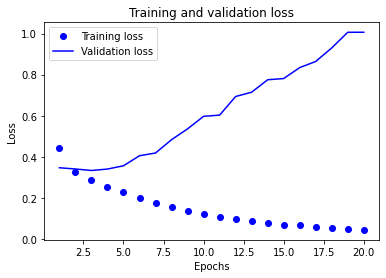

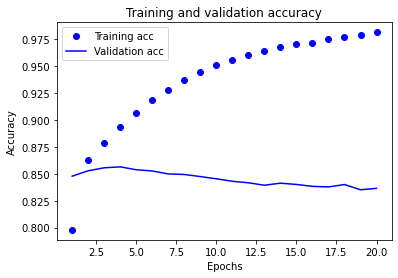

In [13]:
history_dict1 = history1.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict1['accuracy']
val_acc = history_dict1['val_accuracy']
loss = history_dict1['loss']
val_loss = history_dict1['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [14]:
results = model2.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.1798 - accuracy: 0.8233
[1.1797643899917603, 0.8233212232589722]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


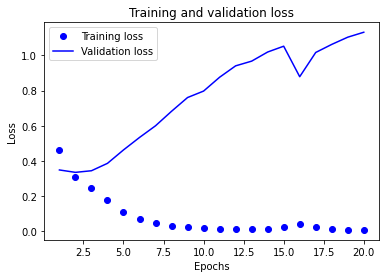

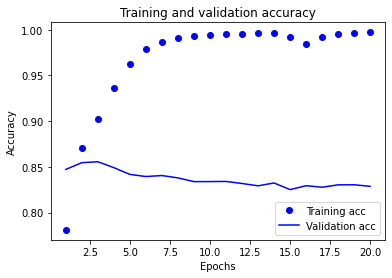

In [15]:
history_dict2 = history2.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict2['accuracy']
val_acc = history_dict2['val_accuracy']
loss = history_dict2['loss']
val_loss = history_dict2['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [16]:
results = model3.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 1s - loss: 0.8447 - accuracy: 0.8308
[0.8446579575538635, 0.8308480978012085]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


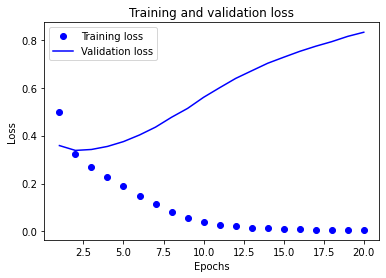

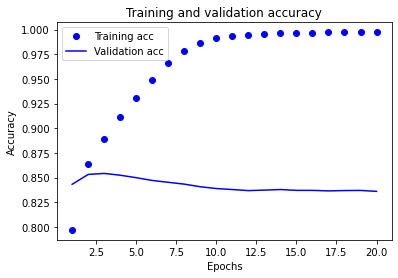

In [17]:
history_dict3 = history3.history
print(history_dict1.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

acc = history_dict3['accuracy']
val_acc = history_dict3['val_accuracy']
loss = history_dict3['loss']
val_loss = history_dict3['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석
가장 성능(정확도)이 좋은 1번 모델의 임베딩을 분석하였다.    
'영화'라는 단어와 비슷한 단어 리스트를 보면 비슷해 보이지 않는 것을 알 수 있다.

In [18]:
embedding_layer = model1.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [19]:
import os
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [20]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['더빙']
vector

array([-1.25662191e-02, -1.91513836e-01, -2.28826590e-02, -7.40566570e-03,
        1.69128284e-01,  1.52913593e-02, -1.54099744e-02, -1.53686807e-01,
        1.06897451e-01, -1.99058801e-02,  4.49116789e-02,  6.75913543e-02,
        1.61691055e-01,  7.27742240e-02, -2.30175257e-03,  3.81094925e-02,
        5.91610633e-02, -7.84288719e-03,  1.73009023e-01, -1.12072043e-02,
        4.15142663e-02,  1.57421529e-02,  6.11892156e-02, -2.99175382e-02,
       -2.79711243e-02, -8.98407251e-02, -1.72636192e-03, -5.04937060e-02,
       -6.36801496e-02,  7.33915120e-02,  6.41438589e-02, -8.98400974e-03,
       -1.24422647e-01,  2.22438723e-02, -7.98286498e-02, -8.77332836e-02,
        6.50159270e-02, -4.68388386e-02, -9.75815393e-03, -8.20475295e-02,
        3.90584916e-02, -3.20018567e-02, -5.10823280e-02, -3.64607014e-02,
       -1.93758328e-02,  1.16607295e-02, -4.63087950e-03,  7.48048052e-02,
       -1.91598669e-01,  4.35634181e-02, -1.54308770e-02, -4.53970134e-02,
        2.62779556e-02,  

In [21]:
word_vectors.similar_by_word("영화")

[('.', 0.4569908380508423),
 ('바라', 0.4435698986053467),
 ('ㅎ', 0.42797645926475525),
 ('어서', 0.4268396496772766),
 ('정말로', 0.4240017235279083),
 ('등장', 0.4008370041847229),
 ('준다', 0.397150456905365),
 ('색다른', 0.3970453143119812),
 ('점', 0.3967747688293457),
 ('음', 0.39263829588890076)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선
미리 훈련된 임베딩을 가져와 기존 model1과 비교한다.    
같은 '영화'라는 단어의 비슷한 단어 리스트를 확인하면 정말 비슷한 단어들이 있는 것을 볼 수 있다.   
그리고 model1에 임베딩을 교체하여 결과를 본다.   
결과는 85%이상이다.

In [22]:
# 미리 훈련된 임베딩 가져오기
import gensim
word2vec_file_path2 = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
pretrain_vec = gensim.models.Word2Vec.load(word2vec_file_path2)
vector = word_vectors['더빙']
vector

array([-1.25662191e-02, -1.91513836e-01, -2.28826590e-02, -7.40566570e-03,
        1.69128284e-01,  1.52913593e-02, -1.54099744e-02, -1.53686807e-01,
        1.06897451e-01, -1.99058801e-02,  4.49116789e-02,  6.75913543e-02,
        1.61691055e-01,  7.27742240e-02, -2.30175257e-03,  3.81094925e-02,
        5.91610633e-02, -7.84288719e-03,  1.73009023e-01, -1.12072043e-02,
        4.15142663e-02,  1.57421529e-02,  6.11892156e-02, -2.99175382e-02,
       -2.79711243e-02, -8.98407251e-02, -1.72636192e-03, -5.04937060e-02,
       -6.36801496e-02,  7.33915120e-02,  6.41438589e-02, -8.98400974e-03,
       -1.24422647e-01,  2.22438723e-02, -7.98286498e-02, -8.77332836e-02,
        6.50159270e-02, -4.68388386e-02, -9.75815393e-03, -8.20475295e-02,
        3.90584916e-02, -3.20018567e-02, -5.10823280e-02, -3.64607014e-02,
       -1.93758328e-02,  1.16607295e-02, -4.63087950e-03,  7.48048052e-02,
       -1.91598669e-01,  4.35634181e-02, -1.54308770e-02, -4.53970134e-02,
        2.62779556e-02,  

In [23]:
pretrain_vec.similar_by_word("영화")

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.7052942514419556),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571459174156189),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428800821304321),
 ('애니메이션', 0.6425570249557495)]

In [24]:
# 가져온 임베딩으로 교체한 모델 실험
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

word2vec = pretrain_vec
# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(word_vector_dim))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 2,322,417
Trainable params: 2,322,417
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
188/188 [==============================] - 6s 34ms/step - loss: 0.4706 - accuracy: 0.7696 - val_loss: 0.3767 - val_accuracy: 0.8305
Epoch 2/5
188/188 [==============================] - 6s 34ms/step - loss: 0.3379 - accuracy: 0.8525 - val_loss: 0.3321 - val_accuracy: 0.8539
Epoch 3/5
188/188 [==============================] - 6s 33ms/step - loss: 0.2869 - accuracy: 0.8792 - val_loss: 0.3247 - val_accuracy: 0.8610
Epoch 4/5
188/188 [==============================] - 6s 33ms/step - loss: 0.2511 - accuracy: 0.8965 - val_loss: 0.3227 - val_accuracy: 0.8617
Epoch 5/5
188/188 [==============================] - 6s 33ms/step - loss: 0.2221 - accuracy: 0.9113 - val_loss: 0.3416 - val_accuracy: 0.8624
1537/1537 - 3s - loss: 0.3482 - accuracy: 0.8577
[0.3481507897377014, 0.8577415347099304]


## 회고 및 루브릭 평가

### 루브릭 평가 항목
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.(3가지 이상의 모델이 성공적으로 시도됨)

2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.(gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함)
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.(네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함)

### 평가 항목에 대한 수행
1. '4) 모델구성 및 validation set 구성'에서 3가지 모델을 만들고 그 후에 테스트까지 정상적으로 하였다.
2. gensim을 유사단어 찾기를 이용하여 '7) 학습된 Embedding 레이어 분석'에서 자체학습 임베딩을 분석하였고, '8) 한국어 Word2Vec 임베딩 활용하여 성능개선'에서 사전학습 임베딩을 분석하였다.
3. 마지막인 '8) 한국어 Word2Vec 임베딩 활용하여 성능개선'에서 테스트 정확도가 85.77%로 85%이상을 달성하였다.

### 회고

노션에 공지된 꼭 포함이 되어야 할 점
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**

---
- **어려웠던 점**    
노드에서 패키지를 설치해야 실행될 수 있는 코드를 주고 무슨 패키지를 설치해야 하는 지 안 알려주는 상황이 있었는데 그 패키지를 설치하는 것이 가장 힘들었던 것 같다. 
---
- **알아낸 점**    
사용한 데이터에 대해서는 학습이 안된 임베딩을 사용할 시에 같은 조건(위에서 사용한 모델)일 때, LSTM, conv, maxpooling 간에 뚜렷한 성능(정확도) 차이가 보이지 않았다. 그리고 생각보다 빠르게 오버피팅이 되는 것을 알 수 있었다. 마지막으로 학습이 비교적 잘 된 임베딩을 쓰면 성능을 높일 수 있었다. 

- **모호한 점**    
왜 빠르게 오버피팅이 되는 지는 궁금하다. 그리고 사전학습이 되지 않은 모델의 경우 디폴트로 epoch을 20으로 하여 훈련을 하였는데 오버피팅이 된 것으로 보아서 epoch을 줄이면 학습이 된 임베딩으로 쓴 것과 결과가 비슷할 것 같아서 과연 단어의 유사도를 잘 찾아내는 임베딩이 여기서 의미가 있을지 의문이다. 추측해보면 이 문제는 문장에서 다음 단어를 예측하는 것이 아닌 문자을 보고 긍정적인지 부정적인지 이진 분류하는 문제여서 단순히 문장의 단어가 긍정적인지 부정적인지를 잘 찾으면 잘 할 수 있는 일이라서 단어의 유사도가 큰 영향을 못 미치는 것 같다.
---
- **시도한 것들**    
노드에서 불친절하게 패키지를 안 알려준 konlpy와 그 하위인 mecab을 설치하는데 https://yuddomack.tistory.com/entry/%EC%B2%98%EC%9D%8C%EB%B6%80%ED%84%B0-%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94-EC2-konlpy-mecab-%EC%84%A4%EC%B9%98%ED%95%98%EA%B8%B0ubuntu 를 참고를 하였다. 사실 처음에는 konlpy만 설치하면 되는 줄 알고 했는데 mecab이 없다는 오류가 나서 참고를 하였다. 여러 가지 모델을 사용해야 해서 LSTM, conv, maxpooling을 사용하여 비교하였다.
---
- **우브릭 평가 관련 지표**   
제 예상에는 모두 달성되었다고 생각한다. 그 이유는 위에 있는 **평가 항목에 대한 수행**에 나와있다.  
- **자기 다짐** 및 **나의 생각들**      
먼저 노드가 불친절해서 기분이 좋지는 않았다. 노드 예제에서 사용하는 패키지 정도는 미리 알려줘야 한다고 생각한다. (노드에서 오류가 날 때마다 스트레스가 쌓이고 있다.) 어쨋든 그렇게 어렵지는 않았는데 이미 예상을 하고 있었기 때문이다. 그 이유는 진표님의 추천으로 https://wikidocs.net/book/2155 여기서 3일 정도 공부를 해서 10 워드임베딩 중간까지 내용을 알고 있었기 때문이다. 그래서 금방 패키지를 설치할 수 있었다. 결국 이 노드를 하는데에 큰 어려움이 없었다. 이번에는 한 번 돌렸는데 성능이 기준인 85%을 넘어서 바로 마칠 수 있었다. 위에서 언급한 대로 사전 학습 없는 모델은 epoch을 20으로 하였는데 오버피팅이 되어서 바로 사전 학습한 모델은 epoch을 줄였다. 평가지표에 좋은 하이퍼파라미터를 찾을라는 얘기가 없어서 사전 학습이 없는 모델의 하이퍼 파라미터을 조정하지는 않았다. 그래서 빠르게 오전 내에 이 노드를 마칠 수 있어서 좋았다. 여기서 배운 점은 nlp 공부를 할 때 이론만 하였는데 실제로 구현해 볼 수 있다는 것을 확인한 것이다. nlp 공부를 혼자 하고 있어서 좀 의욕이 안 생겼는데 실제로 구현하고 나니까 더 해야겠다는 생각이 들었다. 그리고 이제 조금 있으면 어려워지지 않을까라는 기대가 생겼다.